In [431]:
import pandas as pd
import numpy as np

In [432]:
train=pd.read_csv("CSV/train.csv")
test=pd.read_csv("CSV/test.csv")
gender_submission=pd.read_csv("CSV/gender_submission.csv")

## 特徴量エンジニアリング
* データを機械学習用に変換
* データから機械学習用の特徴量を作成

In [433]:
data=pd.concat({'train':train,'test':test},sort=False) #sort=Falseで列の順番を変えない axis=0,1で行列方向に結合 0がデフォ
data["Sex"].replace(["male","female"],[0,1],inplace=True) #inplace=Trueで元のデータを書き換える

get_dummiesでも数値からも文字列に変換可能

In [434]:
# data=pd.get_dummies(train, columns=["Pclass","Sex"])

### 欠損値の穴埋め

In [435]:
data.isnull().sum() #欠損値の確認

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

### Fareの欠損値

In [436]:
data["Fare"].fillna(np.mean(data["Fare"]),inplace=True)

### Embarkedの欠損値

In [437]:
data.describe(include=[object])

,Name,Ticket,Cabin,Embarked
count,1309,1309,295,1307
unique,1307,929,186,3
top,"Connolly, Miss. Kate",CA. 2343,C23 C25 C27,S
freq,2,11,6,914


### アプデの影響でdtype="int64"と指定しないと、bool型になる

In [438]:
data["Embarked"].fillna("S",inplace=True)
data=pd.get_dummies(data,columns=["Embarked"], dtype="int64")
data.head()

PassengerId  Survived  Pclass  \
train 0            1       0.0       3   
      1            2       1.0       1   
      2            3       1.0       3   
      3            4       1.0       1   
      4            5       0.0       3   

                                                      Name  Sex   Age  SibSp  \
train 0                            Braund, Mr. Owen Harris    0  22.0      1   
      1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0      1   
      2                             Heikkinen, Miss. Laina    1  26.0      0   
      3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0      1   
      4                           Allen, Mr. William Henry    0  35.0      0   

         Parch            Ticket     Fare Cabin  Embarked_C  Embarked_Q  \
train 0      0         A/5 21171   7.2500   NaN           0           0   
      1      0          PC 17599  71.2833   C85           1           0   
      2      0  STON/O2. 3101282   7.9250   NaN           0           0   
      3      0            113803  53.1000  C123           0           0   
      4      0            373450   8.0500   NaN           0           0   

         Embarked_S  
train 0           1  
      1           0  
      2           1  
      3           1  
      4           1

### Ageの欠損値
「平均値-標準偏差」から「平均値+標準偏差」の間のランダムな整数値で補間

In [439]:
age_avg=data["Age"].mean()
age_std=data["Age"].std() #standard deviation
data["Age"].fillna(np.random.randint(age_avg-age_std,age_avg+age_std),inplace=True)

### 不要な列の削除

In [440]:
delete_columns=["Name","PassengerId","Ticket","Cabin"]
data.drop(delete_columns,axis=1,inplace=True) #axis=0,1で行,列を削除

## dataをtrain,testに分割

In [441]:
train=data[:len(train)] #最初からlen(train)までの行 列の取得はdata["列名"]
test=data[len(train):]

In [442]:
y_train=train["Survived"]
X_train=train.drop("Survived",axis=1) #axis=0,1で行,列を削除
X_test=test.drop("Survived",axis=1)

Sexは0,1でAgeは80の値をとり、標準化(Standard Scaler)が必要だが、
「ランダムフォレスト」「Light GBM」は標準化などの特徴量変換の影響を受けにくいアルゴリズムの利用が増えており、今回は実装しない

損失はL2正則化、探索手法はsag(Stochastic Average Gradient,確率的平均勾配降下法)

In [443]:
from sklearn.linear_model import LogisticRegression

clf=LogisticRegression(penalty="l2",solver="sag",random_state=0)
clf.fit(X_train,y_train)
print(clf.score(X_train,y_train))
y_pred=clf.predict(X_test)

0.6902356902356902


c:\Users\1612h\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


index=Falseでindex番号を付けないようにする
1.0, 0.0だから整数型に変換

In [444]:
submission=pd.read_csv("CSV/gender_submission.csv")
submission["Survived"]=list(map(int,y_pred))
submission.to_csv("CSV/submission.csv",index=False) #66.5%

## 探索的データ分析

In [445]:
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

### 生存者と死亡者別のAgeのヒストグラム

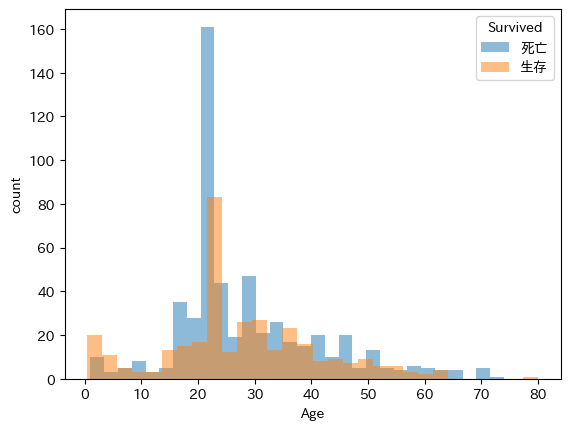

In [446]:
plt.hist(train.loc[train["Survived"]==0, "Age"].dropna(), bins=30, alpha=0.5, label="死亡") #binsで棒の数 alphaで透明度
plt.hist(train.loc[train["Survived"]==1, "Age"], bins=30, alpha=0.5, label="生存")
plt.xlabel("Age")
plt.ylabel("count")
plt.legend(title="Survived")

### 生存者と死亡者別のParchのヒストグラム

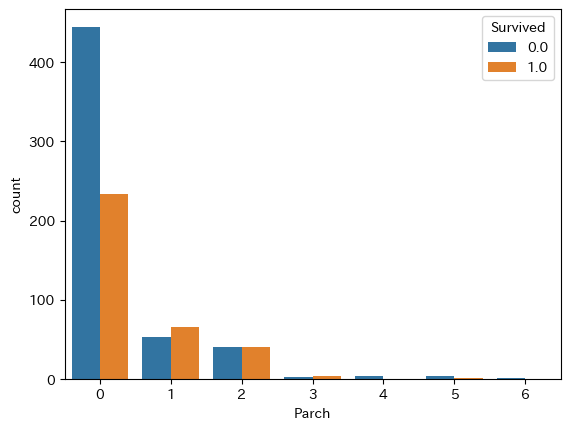

In [447]:
sns.countplot(x="Parch", hue="Survived", data=train) #hueで分類 countplotでカウント
plt.legend(title="Survived", loc="upper right") #upper rightで凡例の位置を右上に指定

### 生存者と死亡者別のFareのヒストグラム

(-5.0, 250.0)

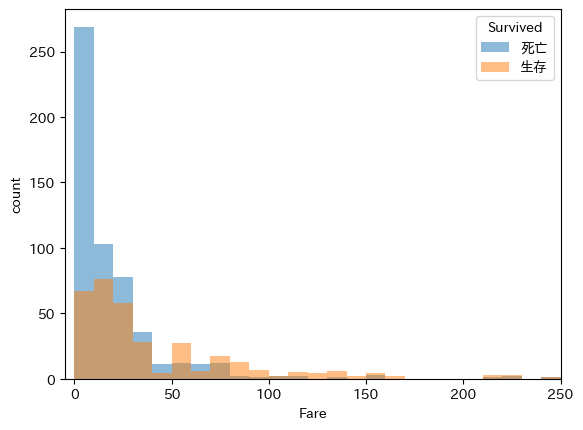

In [448]:
plt.hist(train.loc[train["Survived"]==0, "Fare"].dropna(), range=(0,250), bins=25, alpha=0.5, label="死亡") #rangeで範囲指定 250以上は少ないため
plt.hist(train.loc[train["Survived"]==1, "Fare"].dropna(), range=(0,250), bins=25, alpha=0.5, label="生存") #dropnaで欠損値を除外
plt.xlabel("Fare")
plt.ylabel("count")
plt.legend(title="Survived")
plt.xlim(-5, 250) #x軸の範囲指定

### PclassとSurvivedの棒グラフ

<Axes: xlabel='Pclass', ylabel='count'>

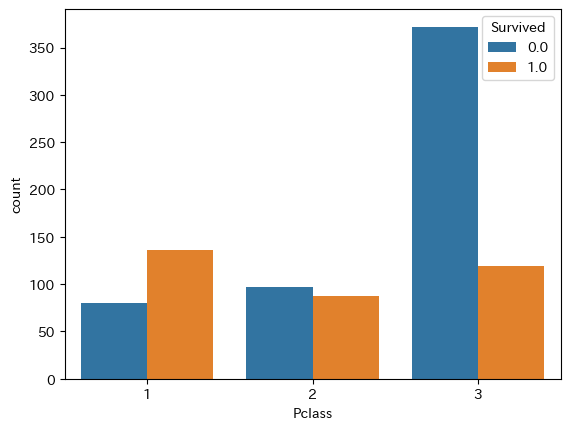

In [449]:
sns.countplot(x="Pclass", hue="Survived", data=train) #hueで色分けしたい列を指定

### SexとSurvivedの棒グラフ

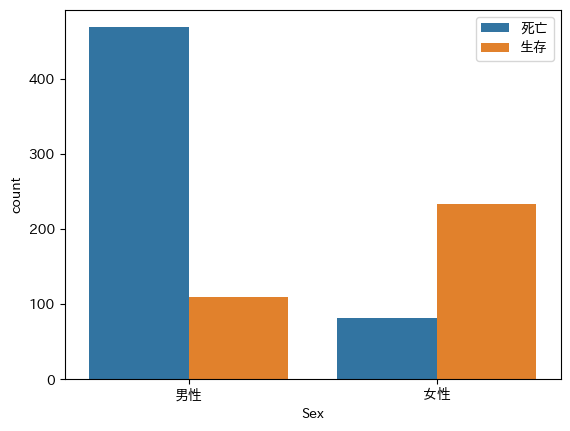

In [450]:
sns.countplot(x="Sex", hue="Survived", data=train)
plt.xticks([0, 1], ['男性', '女性']) #x軸のラベル変更
plt.legend(["死亡", "生存"])

## 仮説に基づいて新しい特徴量を作る

C:\Users\1612h\AppData\Local\Temp\ipykernel_12616\3163201221.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["FamilySize"]=data["FamilySize"[:len(train)]] #列の取得はdata["列名"]
C:\Users\1612h\AppData\Local\Temp\ipykernel_12616\3163201221.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["FamilySize"]=data["FamilySize"][len(train):]


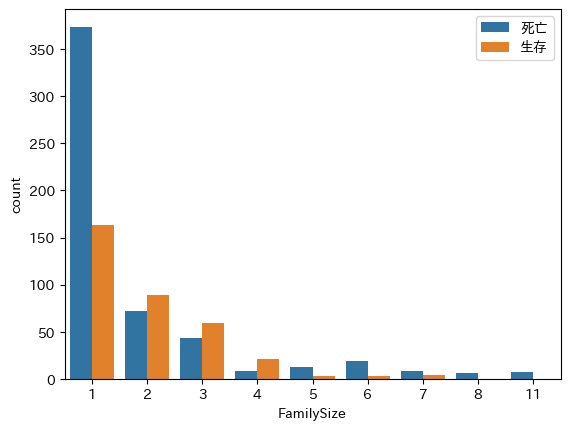

In [451]:
data["FamilySize"]=data["Parch"]+data["SibSp"]+1 #1を足すことで自分も含めた家族の人数
train["FamilySize"]=data["FamilySize"[:len(train)]] #列の取得はdata["列名"]
test["FamilySize"]=data["FamilySize"][len(train):]
sns.countplot(x="FamilySize", data=train, hue="Survived")
plt.legend(["死亡", "生存"])

### ランダムフォレスト

In [452]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
y_pred=clf.predict(X_test)

0.8092031425364759


### LightGBM

In [453]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

clf=LGBMClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
y_pred=clf.predict(X_test)

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [454]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

X_train, X_valid, y_train, y_valid=train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify=y_train) #stratifyでtrainとvalidのラベルの割合を等しく保つ
lgb_train=lgb.Dataset(X_train, y_train) #lgb.Datasetでデータを読み込む
lgb_eval=lgb.Dataset(X_valid, y_valid, reference=lgb_train) #referenceでtrainデータを指定 これでvalidデータの評価がtrainデータと同じになる
param={
    "objective":"binary"
    } #binaryで二値分類

# verbose_evalで学習の進捗を表示num_boost_roundで学習回数 early_stopping_roundsで過学習を防ぐ 10回連続で改善がなければ学習を終了
clf=lgb.train(param, lgb_train, valid_sets=[lgb_train,lgb_eval], num_boost_round=1000) 
y_pred=clf.predict(X_test, num_iteration=clf.best_iteration) #best_iterationで最適な学習回数を指定
y_pred=np.where(y_pred>0.5, 1, 0).astype(int) #0.5以上を1, 0.5未満を0に変換

submission["Survived"]=y_pred
submission.to_csv("CSV/submission.csv", index=False)

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## Optunaでハイパーパラメータの調整
 Optunaはreturnで返す値が最小になるようなハイパーパラメータを探索してくれる
 
 評価指標が損失関数なので、小さいほど望ましい
 * objective：binaryで固定
 * max_bins：255=500の間の整数値を探索
 * learning_rate：0.05で固定
 * num_leaves：32~128の間の整数値を探索

In [455]:
import optuna
from sklearn.metrics import log_loss

def objective(trial):
    params={
        "objective":"binary",
        "max_bin":trial.suggest_int("max_bin", 255, 500),
        "learning_rate":0.05,
        "num_leaves":trial.suggest_int("num_leaves", 32, 128),
    }
    lgb_train=lgb.Dataset(X_train, y_train)
    lgb_eval=lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    clf=lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval], num_boost_round=1000)
    y_pred_valid=clf.predict(X_valid, num_iteration=clf.best_iteration)
    score=log_loss(y_valid, y_pred_valid)
    return score

In [ ]:
study=optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0)) #samplerで乱数のシードを指定
study.optimize(objective, n_trials=40) #optunaの計算を実行 (最小化したい関数, 試行回数)

### 最適なパラメータがstudy.best_paramsに格納される

In [457]:
study.best_params #最適なパラメータを表示

{'max_bin': 390, 'num_leaves': 101}

### 正解率75.358%に向上

In [461]:
params={
    "objective":"binary",
    "max_bin":390,
    "learning_rate":0.05,
    "num_leaves":101
}
lgb_train=lgb.Dataset(X_train, y_train)
lgb_eval=lgb.Dataset(X_valid, y_valid, reference=lgb_train)
clf=lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval], num_boost_round=1000)
y_pred=clf.predict(X_test, num_iteration=clf.best_iteration)
y_pred=np.where(y_pred>0.6, 1, 0).astype(int)

submission["Survived"]=y_pred
submission.to_csv("CSV/submission.csv", index=False)

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 